In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from solpo import Poisson_Equation
from FNO import FNO
from CNN import DeepCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<div class="alert alert-success">
    <h1>Loading Data</h1>
</div>

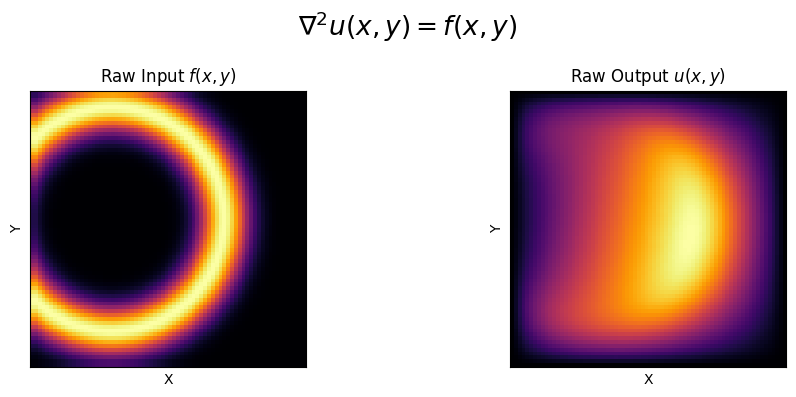

In [58]:
inputs, targets = torch.load("poisson_dataset_test_no_normalization.pt")  # Shape: [N, 1, H, W]

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = inputs.to(device)
targets = targets.to(device)

# Visualize example
idx = np.random.randint(0, 100)
f_img = inputs[idx, 0].cpu().numpy()
u_img = targets[idx, 0].cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
colormap = 'inferno'

axes[0].imshow(f_img, cmap=colormap)
axes[0].set_title("Raw Input $f(x,y)$")

axes[1].imshow(u_img, cmap=colormap)
axes[1].set_title("Raw Output $u(x,y)$")

for i in range(2):
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Y")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# fig.suptitle(r'$\nabla^2 \frac{u(x,y)}{||f(x,y)||_{2}} = \frac{f(x,y)}{||f(x,y)||_{2}}$', fontsize = 19)
fig.suptitle(r'$\nabla^2 u(x,y) = f(x,y)$', fontsize = 19)
plt.tight_layout()
plt.show()


<div class="alert alert-success">
    <h1>Loading Models</h1>
    <ul>
        <li>FNO model</li>
        <li>CNN model</li>
    </ul>
</div>

In [59]:
# Model setup:

# ---FNO---
model_FNO = FNO(modes1=12, modes2=12, width=32)
model_FNO.load_state_dict(torch.load("model_FNO_GELU_complete.pt"))
model_FNO.eval()
model_FNO.to(device)
parameters_FNO = sum(p.numel() for p in model_FNO.parameters() if p.requires_grad)

# ---CNN---
model_CNN = DeepCNN(base_channels=32, num_blocks=4)
model_CNN.load_state_dict(torch.load("model_CNN.pt"))
model_CNN.eval()
model_CNN.to(device)
parameters_CNN = sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)

print(f"Number of parameters FNO: {parameters_FNO}\nNumber of parameters CNN: {parameters_CNN}")

Number of parameters FNO: 1188353
Number of parameters CNN: 74849


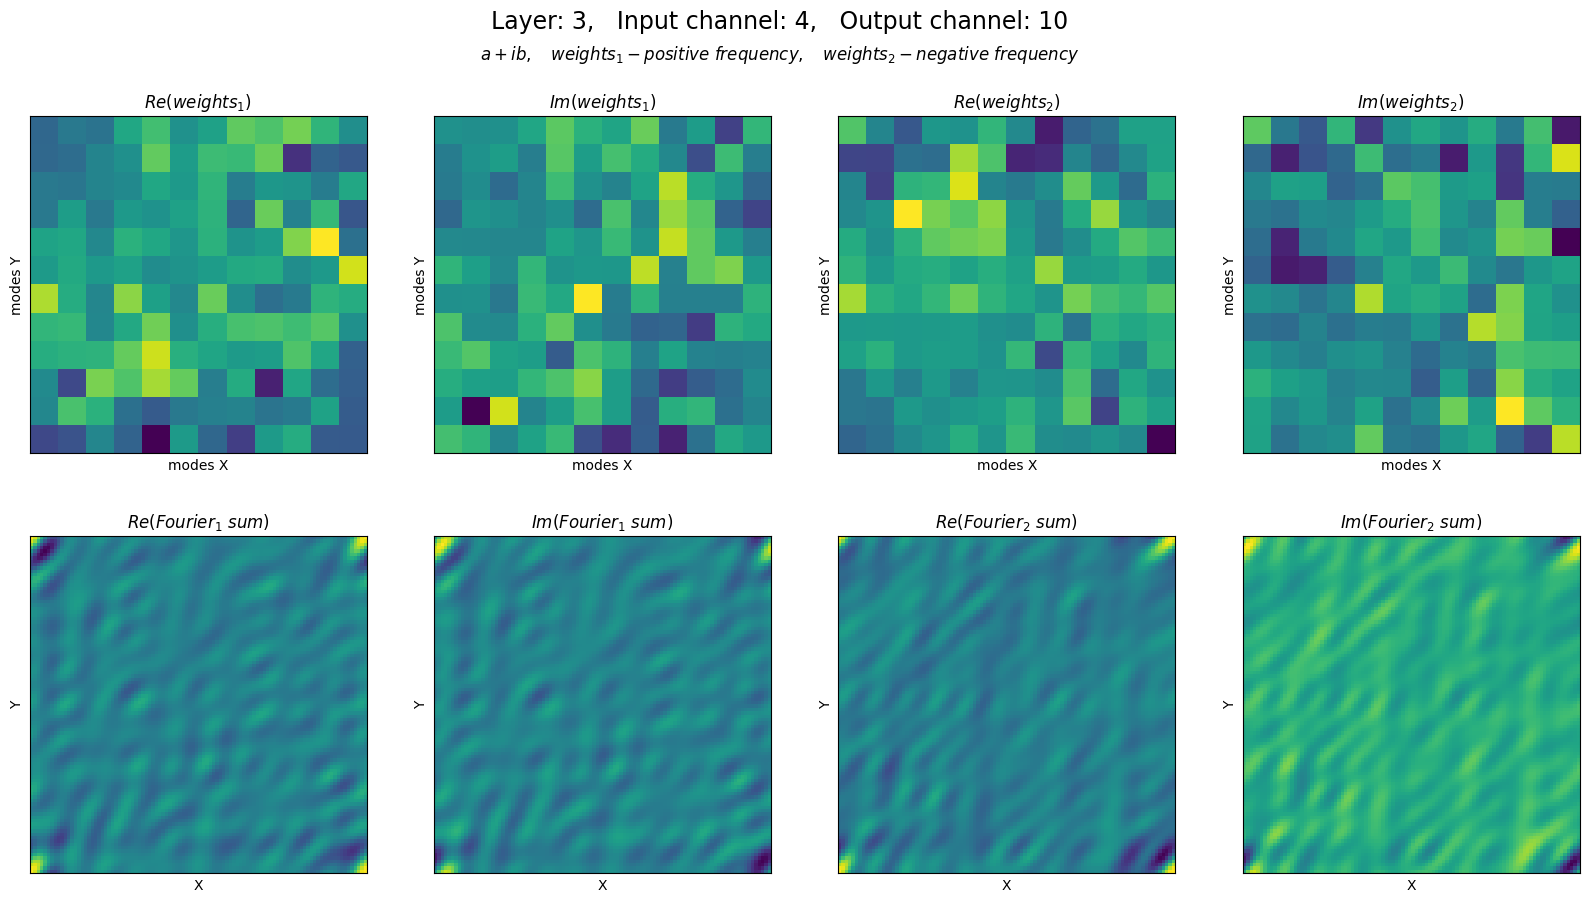

In [60]:
def plot_modes_and_operators(model, layer_idx=1, in_ch=0, out_ch=0):
    spectral_layers = [model.spec0, model.spec1, model.spec2, model.spec3]
    layer = spectral_layers[layer_idx]

    weights1 = layer.weights1[in_ch, out_ch].detach().cpu()
    weights2 = layer.weights2[in_ch, out_ch].detach().cpu()

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    colormap = 'viridis'

    axes[0][0].imshow(weights1.real.numpy(), cmap=colormap)
    axes[0][0].set_title("$Re(weights_1)$")

    axes[0][1].imshow(weights1.imag.numpy(), cmap=colormap)
    axes[0][1].set_title("$Im(weights_1)$")

    axes[0][2].imshow(weights2.real.numpy(), cmap=colormap)
    axes[0][2].set_title("$Re(weights_2)$")

    axes[0][3].imshow(weights2.imag.numpy(), cmap=colormap)
    axes[0][3].set_title("$Im(weights_2)$")

    for i in range(4):
        axes[0][i].set_xlabel("modes X")
        axes[0][i].set_ylabel("modes Y")
        axes[0][i].set_xticks([])
        axes[0][i].set_yticks([])

    grid_size = 100

    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y, indexing='ij')

    modes1_num, modes2_num = weights1.shape[0], weights1.shape[1]
    combined_field1 = np.zeros((grid_size, grid_size), dtype=np.complex128)
    combined_field2 = np.zeros((grid_size, grid_size), dtype=np.complex128)


    for i in range(modes1_num):
        for j in range(modes2_num):
            coeff1 = weights1[i, j].item()  # complex scalar --> C_{m,n}
            coeff2 = weights2[i, j].item() 
            basis = np.exp(2j * np.pi * (i * X + j * Y))  # complex basis function --> 1j is the imaginary unit
            combined_field1 += coeff1 * basis 
            combined_field2 += coeff2 * basis 

    real1, imaginary1, real2, imaginary2 = np.real(combined_field1), np.imag(combined_field1), np.real(combined_field2), np.imag(combined_field2)

    axes[1][0].imshow(real1, cmap=colormap)
    axes[1][0].set_title(r"$Re(Fourier_1 \ sum)$")

    axes[1][1].imshow(imaginary1, cmap=colormap)
    axes[1][1].set_title(r"$Im(Fourier_1 \ sum)$")

    axes[1][2].imshow(real2, cmap=colormap)
    axes[1][2].set_title(r"$Re(Fourier_2 \ sum)$")

    axes[1][3].imshow(imaginary2, cmap=colormap)
    axes[1][3].set_title(r"$Im(Fourier_2 \ sum)$")

    for i in range(4):
        axes[1][i].set_xlabel("X")
        axes[1][i].set_ylabel("Y")
        axes[1][i].set_xticks([])
        axes[1][i].set_yticks([])
    
    fig.suptitle(f'Layer: {layer_idx},   Input channel: {in_ch},   Output channel: {out_ch}', fontsize=17)
    fig.text(0.5, 0.93, r'$a+ib, \quad weights_1 - positive \ frequency, \quad weights_2 - negative \ frequency$', ha='center', fontsize=12)
    
    plt.show()


plot_modes_and_operators(model=model_FNO, layer_idx=3, in_ch=4, out_ch=10)

---

$
\sum_{k_1, k_2} C^{(1)}_{k_1, k_2} \cdot e^{2\pi i (k_1 x + k_2 y)} \quad \quad \text{weights}_{1} \text{ – positive frequencies}
$

$
\sum_{k_1, k_2} C^{(2)}_{-k_1, k_2} \cdot e^{2\pi i (-k_1 x + k_2 y)} \quad \text{weights}_{2} \text{ – negative frequencies}
$

---

$
\hat{u}_{k_1, k_2} =
\begin{cases}
\sum_{\text{Cin}} W^{(1)}_{k_1, k_2} \cdot \hat{f}_{k_1, k_2}, & \quad 0 \leq k_1 < \text{modes1} \\\\
\sum_{\text{Cin}} W^{(2)}_{k_1, k_2} \cdot \hat{f}_{k_1, k_2}, & \quad -\text{modes1} \leq k_1 < 0 \\\\
0, & \quad \text{otherwise}
\end{cases}
$


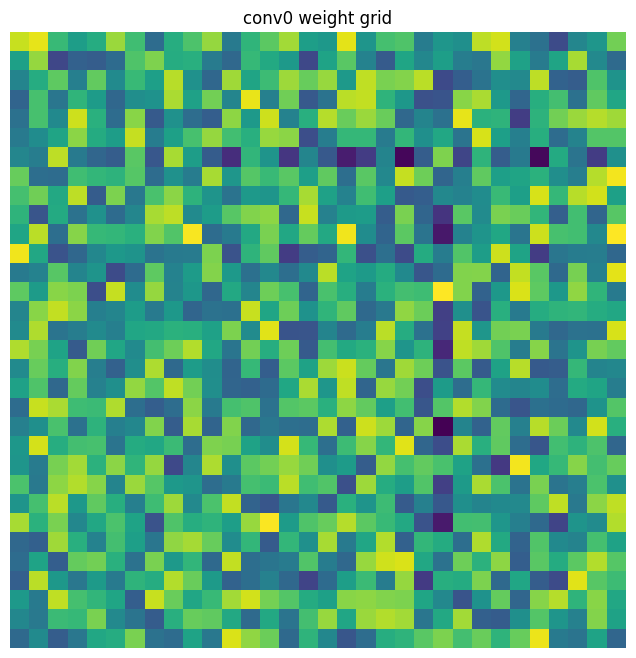

In [74]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_conv_weights_as_image(layer, title="All Conv Weights", normalize=True):
    weights = layer.weight.detach().cpu()  # shape: [out_ch, in_ch, H, W]
    out_ch, in_ch, H, W = weights.shape

    # Flatten into grid: each kernel is HxW, total (out_ch * in_ch) kernels
    weight_images = weights.view(-1, H, W)

    if normalize:
        weight_images = (weight_images - weight_images.min()) / (weight_images.max() - weight_images.min() + 1e-6)

    # Compute grid layout
    N = weight_images.shape[0]
    grid_size = int(np.ceil(np.sqrt(N)))
    canvas = torch.zeros((grid_size * H, grid_size * W))

    for idx in range(N):
        i = idx // grid_size
        j = idx % grid_size
        canvas[i*H:(i+1)*H, j*W:(j+1)*W] = weight_images[idx]

    plt.figure(figsize=(8, 8))
    plt.imshow(canvas.numpy(), cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()
show_conv_weights_as_image(model_FNO.conv2, title="conv0 weight grid")


<div class="alert alert-success">
    <h1>Prediction Generation</h1>
</div>

In [63]:
inputs_FNO = inputs.permute(0, 2, 3, 1).to(device)
inputs_CNN = inputs.to(device)

with torch.no_grad():
    preds_FNO, preds_CNN = model_FNO(inputs_FNO), model_CNN(inputs_CNN)

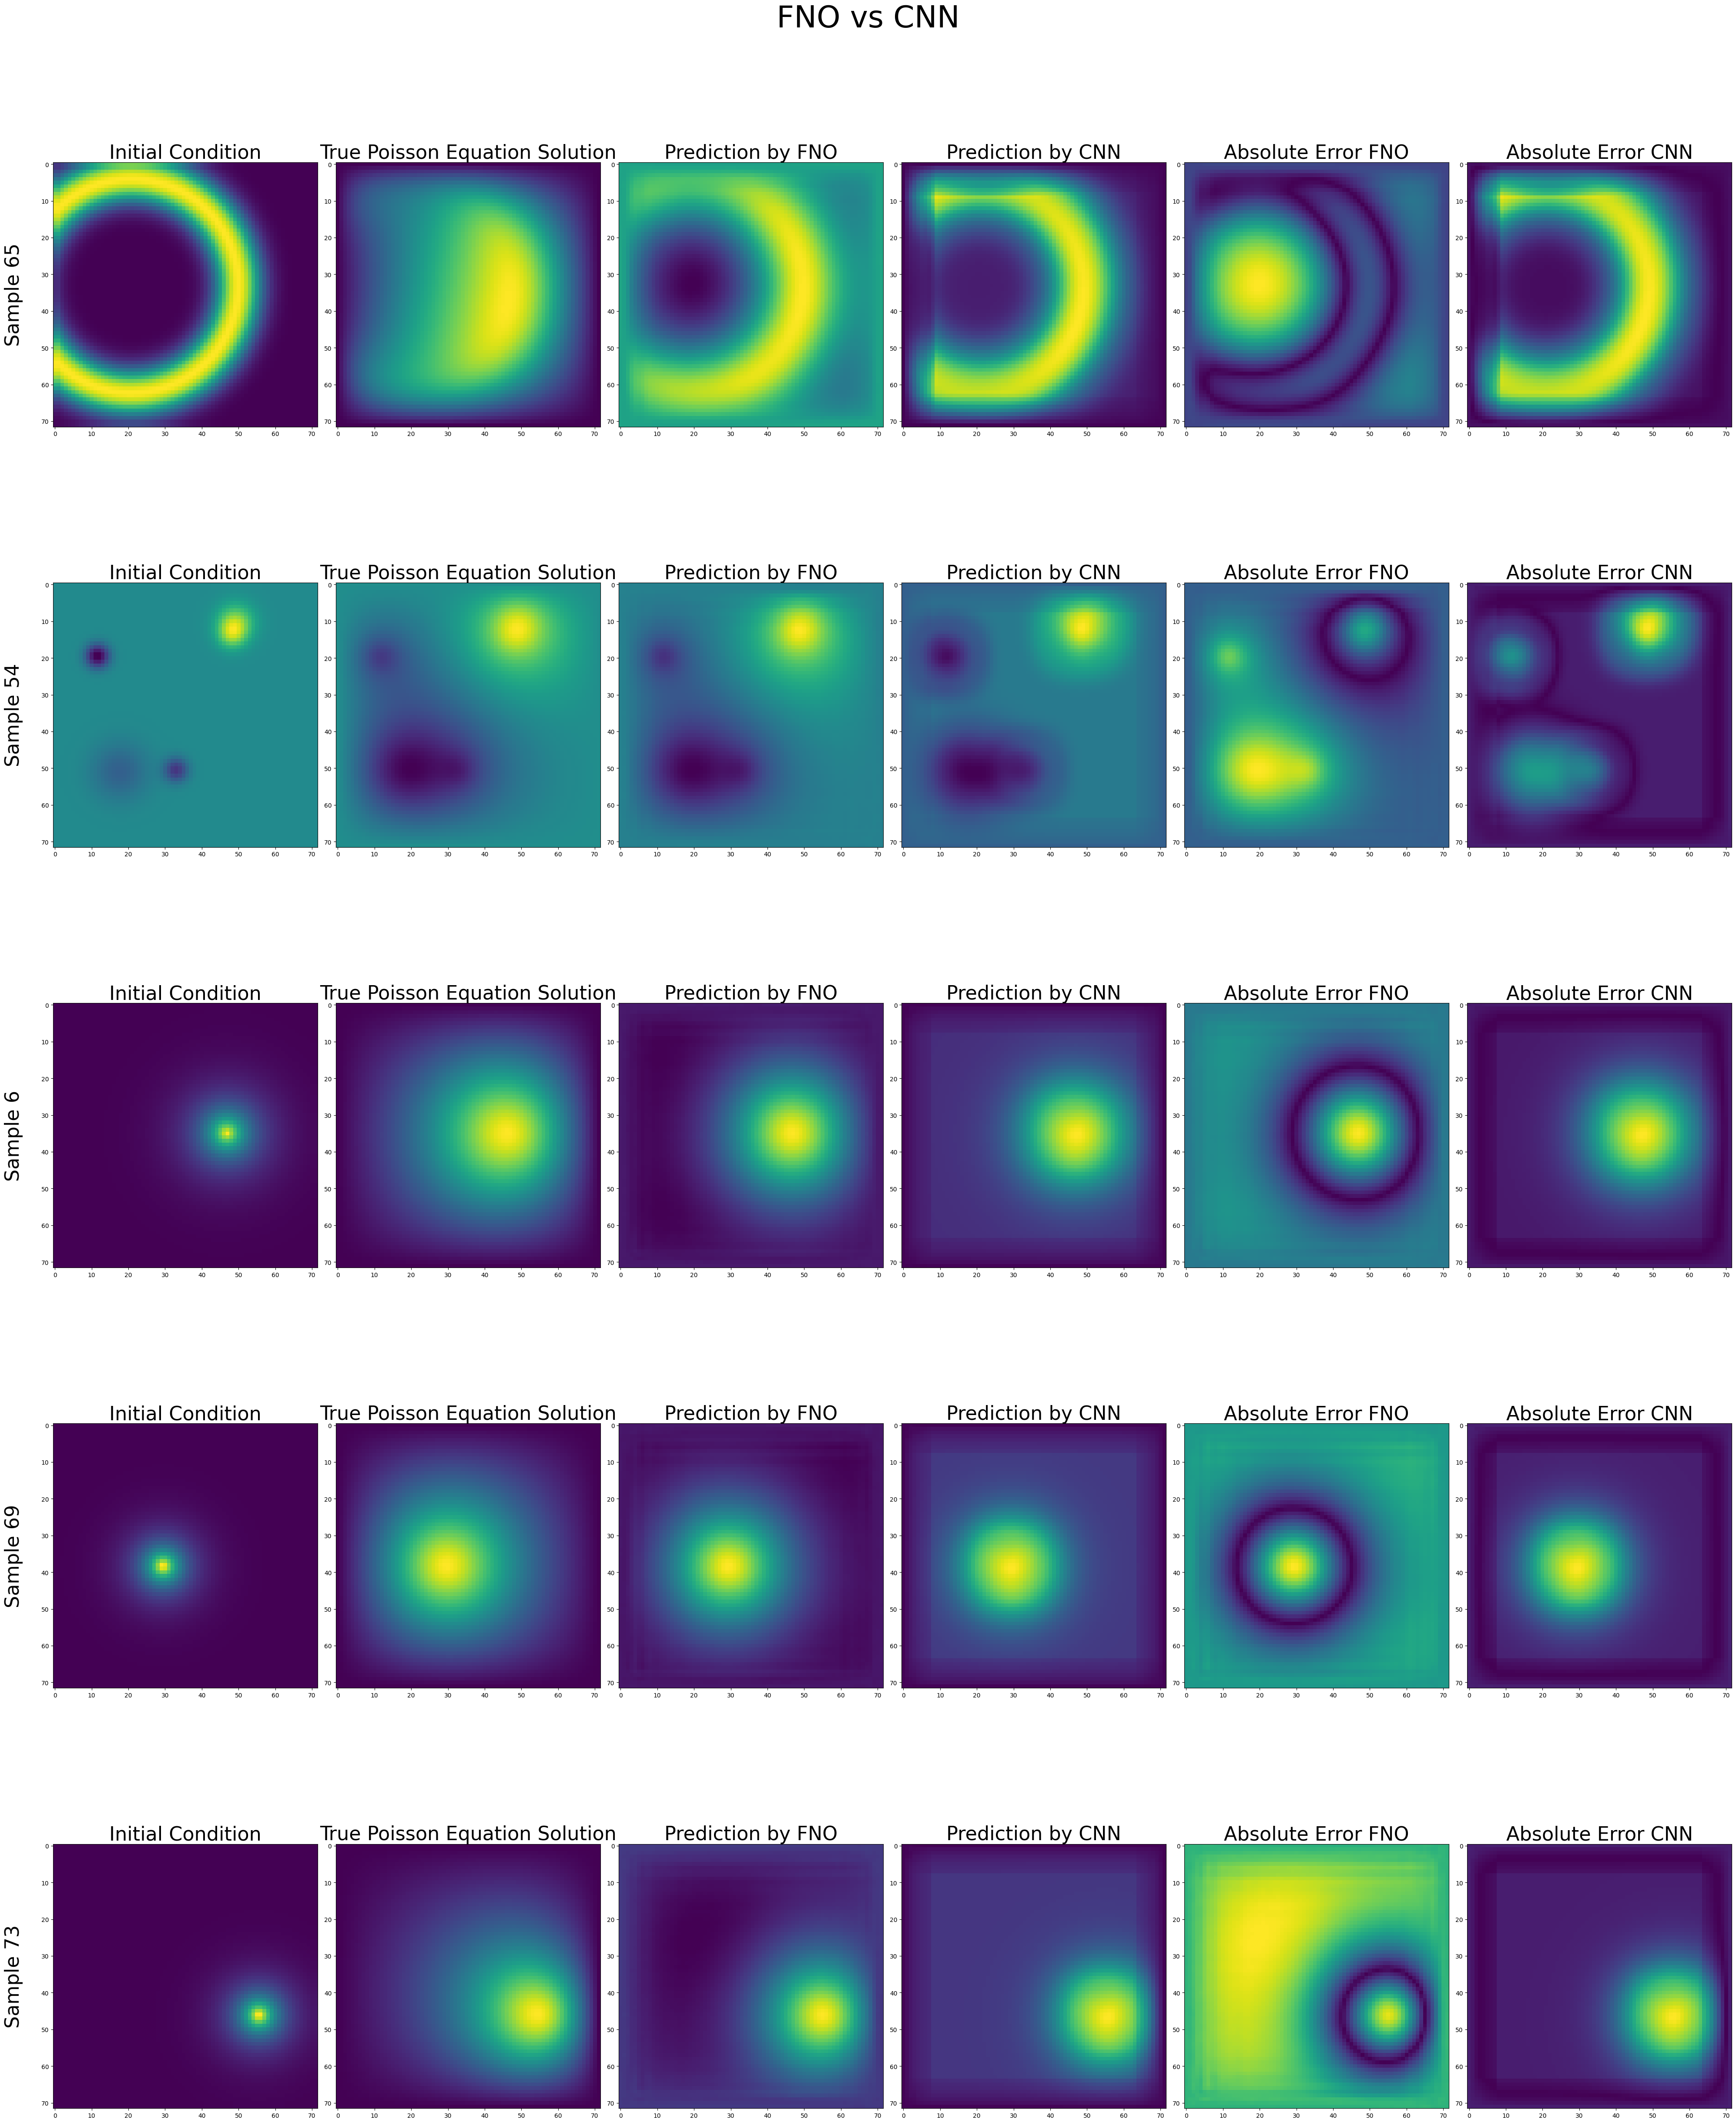

In [64]:
n_samples = 5

initial_condition = []
poisson_solution  = []
predicition_FNO   = []
predicition_CNN   = []
sample_index      = []

for i in range(n_samples):
    rand_num = torch.randint(1, 100, (1,))
    idx = rand_num.item()
    sample_index.append(idx)
    Xf = inputs[idx].squeeze().cpu()
    initial_condition.append(Xf)
    Zi = targets[idx].squeeze().cpu()
    poisson_solution.append(Zi)
    Zp0 = preds_FNO[idx].squeeze().cpu()
    predicition_FNO.append(Zp0)
    Zp1 = preds_CNN[idx].squeeze().cpu()
    predicition_CNN.append(Zp1)

fig, axes = plt.subplots(ncols=6, nrows=n_samples, figsize=(40, 10*n_samples))
fontsize = 32
for i in range(n_samples):
    axes[i][0].imshow(initial_condition[i], cmap='viridis')
    axes[i][0].set_title("Initial Condition", fontsize=fontsize)
    axes[i][1].imshow(poisson_solution[i], cmap='viridis')
    axes[i][1].set_title("True Poisson Equation Solution", fontsize=fontsize)
    axes[i][2].imshow(predicition_FNO[i], cmap='viridis')
    axes[i][2].set_title("Prediction by FNO", fontsize=fontsize)
    axes[i][3].imshow(predicition_CNN[i], cmap='viridis')
    axes[i][3].set_title("Prediction by CNN", fontsize=fontsize)
    axes[i][4].imshow(abs(poisson_solution[i] - predicition_FNO[i]), cmap='viridis')
    axes[i][4].set_title("Absolute Error FNO", fontsize=fontsize)
    axes[i][5].imshow(abs(poisson_solution[i] - predicition_CNN[i]), cmap='viridis')
    axes[i][5].set_title("Absolute Error CNN", fontsize=fontsize)


    axes[i][0].set_ylabel(f"Sample {sample_index[i]}", fontsize=fontsize, rotation=90, labelpad=30)
plt.tight_layout()
fig.suptitle('FNO vs CNN', fontsize=50, y=1.02)
plt.savefig('Comparison_Pixels.pdf', bbox_inches='tight')
plt.show()

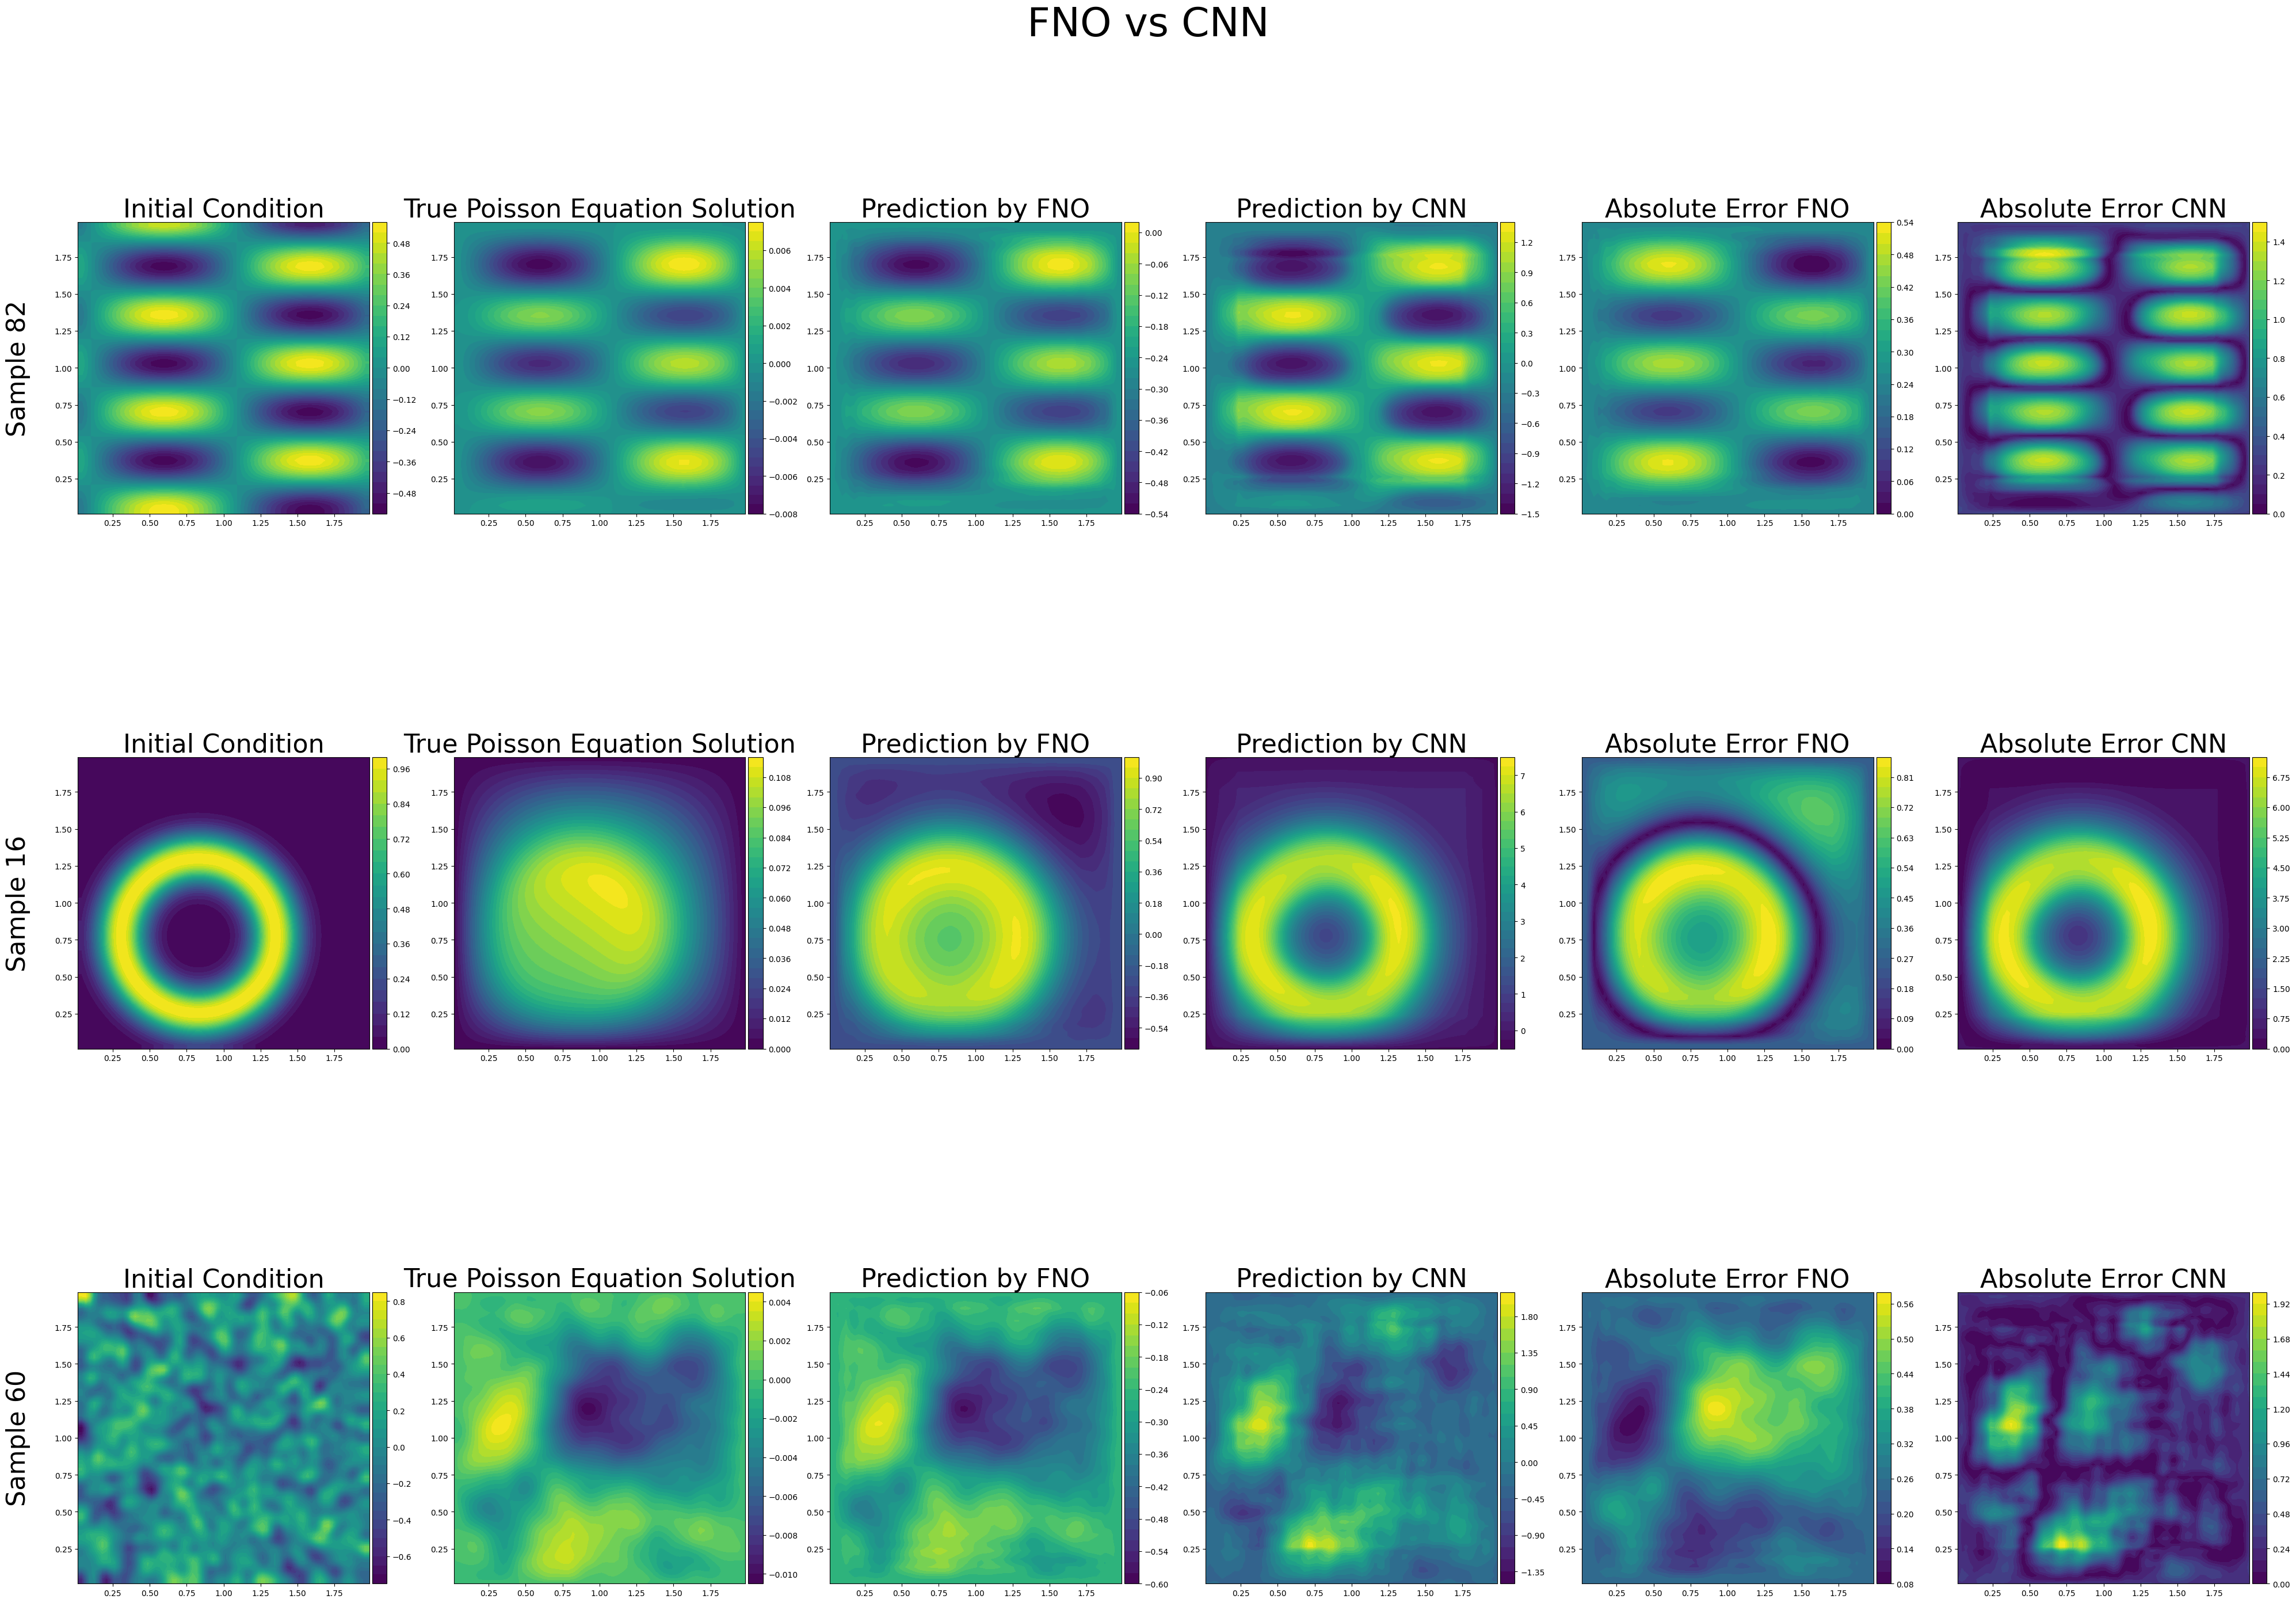

In [65]:
extent = [0, 2, 0, 2] 
n_samples = 3
epsilon = 1e-3

initial_condition = []
poisson_solution  = []
predicition_FNO   = []
predicition_CNN   = []
sample_index      = []

for i in range(n_samples):
    rand_num = torch.randint(1, 100, (1,))
    idx = rand_num.item()
    sample_index.append(idx)
    Xf = inputs[idx].squeeze().cpu()
    initial_condition.append(Xf)
    Zi = targets[idx].squeeze().cpu()
    poisson_solution.append(Zi)
    Zp0 = preds_FNO[idx].squeeze().cpu()
    predicition_FNO.append(Zp0)
    Zp1 = preds_CNN[idx].squeeze().cpu()
    predicition_CNN.append(Zp1)

fig, axes = plt.subplots(ncols=6, nrows=n_samples, figsize=(40, 10*n_samples))
fontsize = 32
contour_num = 30
for i in range(n_samples):

    cs0 = axes[i][0].contourf(initial_condition[i], levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][0].set_title("Initial Condition", fontsize=fontsize)
    cs1 = axes[i][1].contourf(poisson_solution[i], levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][1].set_title("True Poisson Equation Solution", fontsize=fontsize)
    cs2 = axes[i][2].contourf(predicition_FNO[i], levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][2].set_title("Prediction by FNO", fontsize=fontsize)
    cs3 = axes[i][3].contourf(predicition_CNN[i], levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][3].set_title("Prediction by CNN", fontsize=fontsize)
    cs4 = axes[i][4].contourf(abs(poisson_solution[i] - predicition_FNO[i]), levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][4].set_title("Absolute Error FNO", fontsize=fontsize)
    cs5 = axes[i][5].contourf(abs(poisson_solution[i] - predicition_CNN[i]), levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][5].set_title("Absolute Error CNN", fontsize=fontsize)

    axes[i][0].set_ylabel(f"Sample {sample_index[i]}", fontsize=fontsize, rotation=90, labelpad=30)
    
    for j, cs in enumerate([cs0, cs1, cs2, cs3, cs4, cs5]):
        divider = make_axes_locatable(axes[i][j])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(cs, ax=axes[i][j], cax=cax)
        axes[i][j].set_aspect('equal')

plt.tight_layout()

fig.suptitle('FNO vs CNN', fontsize=50, y=1.02)
plt.savefig('Comparison_Contours.pdf', bbox_inches='tight')
plt.show()

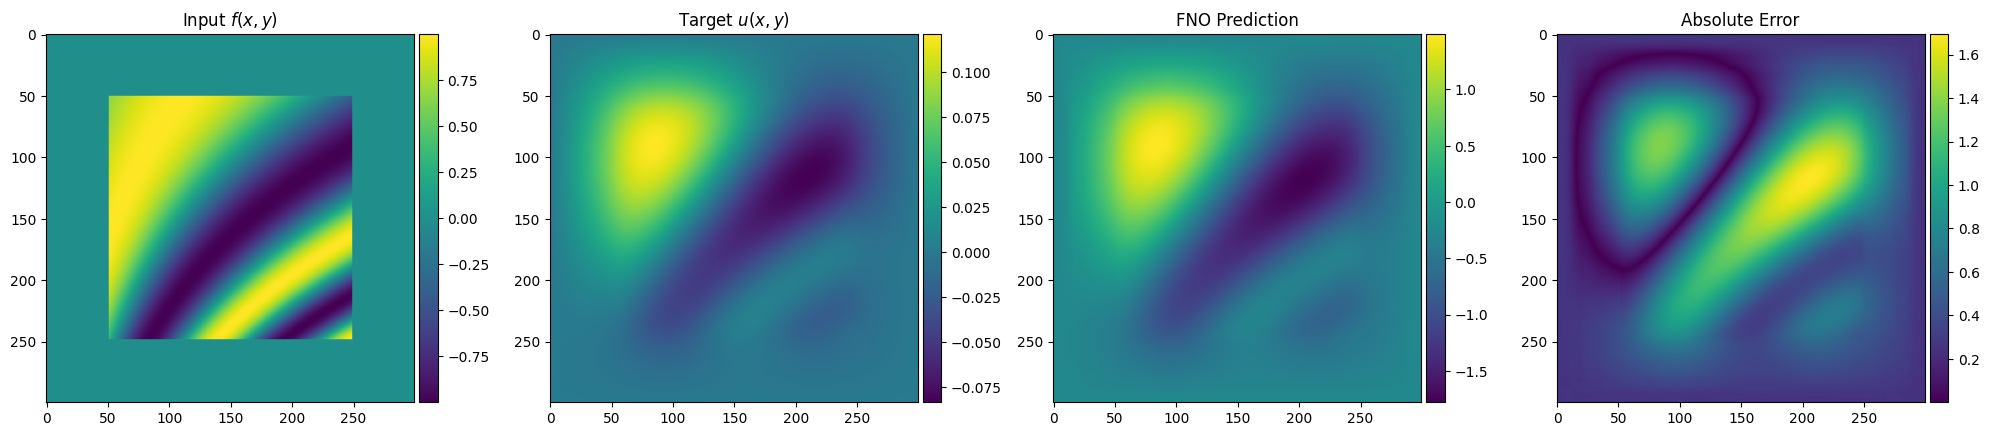

In [66]:
# Parameters
H = 3
n = 300

# Source function
def f_raw(x, y):
    x = x - H / 2
    y = y - H / 2
    return np.sin((x**2 + y**2)*3)

def f_raw(x, y):
    a, b = np.random.randint(5, 10), np.random.randint(1, 5)
    x0, y0 = H / 2, H / 2
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    theta = np.arctan2(y - y0, x - x0)
    return np.where(np.sin(a * theta) * b <= r**2, 1, 0)

def f_raw(x, y):
    d, d1, d2 = np.random.uniform(0.4, H-0.4, 1), np.random.uniform(0.4, H/2, 1), np.random.uniform(H/2, H-0.4, 1)
    r1, r2 = np.random.uniform(0.2, 0.4, 2)
    dist_pos = (x - d2)**2 + (y - d)**2
    dist_neg = (x - d1)**2 + (y - d)**2
    result = np.where(dist_pos <= r1**2, 1, 0)
    charges = np.where(dist_neg <= r2**2, -1, result)
    return charges

def f_raw(x, y):
    x_shifted = x - H / 2
    y_shifted = y - H / 2
    r = np.sqrt(x_shifted**2 + y_shifted**2)
    theta = np.arctan2(y_shifted, x_shifted)
    f = np.where(np.sin(9 * theta) * 3 >= r**2, 3, 0)
    f = np.sin(x*y*5)
    f = np.where(
        (x > 0.5) & (x < H - 0.5) & (y > 0.5) & (y < H - 0.5),
        1, 0
    )
    return f*np.sin(2**y*x)

# Meshgrid
x = np.linspace(0, H, n-2)
y = np.linspace(0, H, n-2)
X, Y = np.meshgrid(x, y)

# Source input
f_vals_raw = f_raw(X, Y)

# Solve Poisson with raw input
PE = Poisson_Equation(H=H, n=n - 2, IC=lambda x,y: f_vals_raw)
u_raw = PE.solve_Poisson_Equation()

# Prepare input tensor for FNO
f_padded = np.pad(f_vals_raw, pad_width=1, mode='edge')
input_tensor = torch.tensor(f_padded, dtype=torch.float32).unsqueeze(-1).unsqueeze(0).to(device)

# Load pretrained model
model = FNO(modes1=12, modes2=12, width=32)
model.load_state_dict(torch.load("model_FNO_GELU_complete.pt"))
model.eval().to(device)

# Predict with FNO
with torch.no_grad():
    pred_tensor = model(input_tensor)

# Extract results
pred_img = pred_tensor.squeeze().cpu().numpy()

# Plot comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
titles = [
    "Input $f(x,y)$",
    "Target $u(x,y)$",
    "FNO Prediction",
    "Absolute Error"
]
images = [
    f_padded,
    u_raw,
    pred_img,
    np.abs(pred_img - u_raw)
]

for ax, title, img in zip(axes, titles, images):
    im = ax.imshow(img, cmap="viridis")
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

In [67]:
from skimage.metrics import structural_similarity as ssim

mse = np.mean((u_raw - pred_img) ** 2)
mae = np.mean(np.abs(u_raw - pred_img))
relative_l2 = np.linalg.norm(u_raw - pred_img) / np.linalg.norm(u_raw)
psnr = 20 * np.log10(np.max(u_raw) / np.sqrt(mse))
score = ssim(u_raw, pred_img, data_range=pred_img.max() - pred_img.min())


print(f'MSE  = {mse}\nMAE  = {mae}\nRL2  = {relative_l2}\nPSNR = {psnr}\nSimS = {score}')

MSE  = 0.44891493132889804
MAE  = 0.5463773368206646
RL2  = 16.855117736576435
PSNR = -14.86827468211235
SimS = 0.0778539979741765
